<a href="https://colab.research.google.com/github/kitamigo/pms/blob/main/BART_T5_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("No GPU - Set")

GPU: Tesla T4
Memory: 15.8 GB


In [2]:
!pip install -q transformers datasets evaluate accelerate rouge-score nltk sentencepiece
print("\nPip packages installed")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00

Pip packages installed


In [4]:
from google.colab import drive
import os

drive.mount('/content/drive')
project_dir = '/content/drive/MyDrive/clario-models'
os.makedirs(project_dir, exist_ok=True)
print(f"Models will be saved to: {project_dir}")

Mounted at /content/drive
Models will be saved to: /content/drive/MyDrive/clario-models


In [5]:
# Dataset settings
DATASET = "cnn_dailymail"
DATASET_CONFIG = "3.0.0"
SAMPLE_SIZE = 10000

# Training settings
EPOCHS = 3
BATCH_SIZE = 4
LEARNING_RATE = 5e-5
GRADIENT_ACCUM = 4

# Model settings
BART_MODEL = "facebook/bart-base"
BART_MAX_INPUT = 1024
BART_MAX_OUTPUT = 128

T5_MODEL = "t5-base"
T5_MAX_INPUT = 512
T5_MAX_OUTPUT = 200

# Output
try:
    OUTPUT_BASE = '/content/drive/MyDrive/clario-models'
except:
    OUTPUT_BASE = '/content/models'
    os.makedirs(OUTPUT_BASE, exist_ok=True)

print(f"Dataset: {DATASET} ({SAMPLE_SIZE} samples)")
print(f"Training: {EPOCHS} epochs, batch size {BATCH_SIZE}")
print(f"Output: {OUTPUT_BASE}")

Dataset: cnn_dailymail (10000 samples)
Training: 3 epochs, batch size 4
Output: /content/drive/MyDrive/clario-models


In [6]:
from datasets import load_dataset
import numpy as np

print(f"\nDownloading {DATASET}")

if DATASET_CONFIG:
    dataset = load_dataset(DATASET, DATASET_CONFIG)
else:
    dataset = load_dataset(DATASET)

# Sample dataset
if SAMPLE_SIZE < len(dataset['train']):
    indices = np.random.choice(len(dataset['train']), SAMPLE_SIZE, replace=False)
    dataset['train'] = dataset['train'].select(indices)

    if 'validation' in dataset:
        val_size = min(int(SAMPLE_SIZE * 0.1), len(dataset['validation']))
        val_indices = np.random.choice(len(dataset['validation']), val_size, replace=False)
        dataset['validation'] = dataset['validation'].select(val_indices)

print(f"Train: {len(dataset['train'])} samples")
if 'validation' in dataset:
    print(f"Validation: {len(dataset['validation'])} samples")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Train: 10000 samples
Validation: 1000 samples


In [7]:
from transformers import AutoTokenizer

# Load tokenizers
bart_tokenizer = AutoTokenizer.from_pretrained(BART_MODEL)
t5_tokenizer = AutoTokenizer.from_pretrained(T5_MODEL)

# Preprocessing
def preprocess_bart(examples):
    if DATASET == "cnn_dailymail":
        texts = examples['article']
        summaries = examples['highlights']
    elif DATASET == "xsum":
        texts = examples['document']
        summaries = examples['summary']
    elif DATASET == "samsum":
        texts = examples['dialogue']
        summaries = examples['summary']

    inputs = bart_tokenizer(texts, max_length=BART_MAX_INPUT, truncation=True, padding=False)
    labels = bart_tokenizer(summaries, max_length=BART_MAX_OUTPUT, truncation=True, padding=False)
    inputs["labels"] = labels["input_ids"]
    return inputs

def preprocess_t5(examples):
    if DATASET == "cnn_dailymail":
        texts = examples['article']
        summaries = examples['highlights']
    elif DATASET == "xsum":
        texts = examples['document']
        summaries = examples['summary']
    elif DATASET == "samsum":
        texts = examples['dialogue']
        summaries = examples['summary']

    texts = ["summarize: " + t for t in texts]
    inputs = t5_tokenizer(texts, max_length=T5_MAX_INPUT, truncation=True, padding=False)
    labels = t5_tokenizer(summaries, max_length=T5_MAX_OUTPUT, truncation=True, padding=False)
    inputs["labels"] = labels["input_ids"]
    return inputs

# Tokenize
print("Preprocessing for BART in progress")
bart_dataset = dataset.map(preprocess_bart, batched=True, remove_columns=dataset['train'].column_names)

print("Preprocessing for T5 in progress")
t5_dataset = dataset.map(preprocess_t5, batched=True, remove_columns=dataset['train'].column_names)

print("Preprocessing complete")

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Preprocessing for BART...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

Preprocessing for T5...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

Preprocessing complete!


In [8]:
import evaluate
import numpy as np

rouge = evaluate.load("rouge")

def compute_metrics_bart(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = bart_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, bart_tokenizer.pad_token_id)
    decoded_labels = bart_tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v, 4) for k, v in result.items()}

def compute_metrics_t5(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = t5_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, t5_tokenizer.pad_token_id)
    decoded_labels = t5_tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v, 4) for k, v in result.items()}

print("\nTraining utilities ready")


Training utilities ready


In [11]:
from transformers import BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq, EarlyStoppingCallback
import numpy as np

def compute_metrics_bart(eval_pred):
    """Compute ROUGE metrics during evaluation"""
    predictions, labels = eval_pred

    predictions = np.where(predictions != -100, predictions, bart_tokenizer.pad_token_id).astype(int)

    vocab_size = bart_tokenizer.vocab_size
    predictions = np.clip(predictions, 0, vocab_size - 1)

    # Decode predictions
    decoded_preds = bart_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, bart_tokenizer.pad_token_id).astype(int)
    labels = np.clip(labels, 0, vocab_size - 1)
    decoded_labels = bart_tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores using the globally defined rouge object
    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Extract F1 scores
    result = {
        "rouge1": rouge_result["rouge1"] if "rouge1" in rouge_result else 0.0,
        "rouge2": rouge_result["rouge2"] if "rouge2" in rouge_result else 0.0,
        "rougeL": rouge_result["rougeL"] if "rougeL" in rouge_result else 0.0,
        "rougeLsum": rouge_result["rougeLsum"] if "rougeLsum" in rouge_result else 0.0
    }

    return {k: round(v, 4) for k, v in result.items()}

print("-"*25)
print("Training BART")
print("-"*25)

bart_model = BartForConditionalGeneration.from_pretrained(BART_MODEL)
print(f"Loaded {BART_MODEL}")

bart_output = f"{OUTPUT_BASE}/bart-{DATASET}"

training_args = Seq2SeqTrainingArguments(
    output_dir=bart_output,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_steps=500,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=GRADIENT_ACCUM,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    predict_with_generate=True,
    generation_max_length=BART_MAX_OUTPUT,
    logging_steps=100,
    report_to=[],
    push_to_hub=False
)

data_collator = DataCollatorForSeq2Seq(bart_tokenizer, model=bart_model, padding=True)

trainer = Seq2SeqTrainer(
    model=bart_model,
    args=training_args,
    train_dataset=bart_dataset['train'],
    eval_dataset=bart_dataset.get('validation'),
    processing_class=bart_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_bart,
    callbacks=[EarlyStoppingCallback(3)]
)

print("\nStarting training")
trainer.train()

print("\nSaving model")
trainer.save_model(f"{bart_output}/final")
bart_tokenizer.save_pretrained(f"{bart_output}/final")

if bart_dataset.get('validation'):
    metrics = trainer.evaluate()
    print("\nBART Results:")
    print(f"  ROUGE-1: {metrics.get('eval_rouge1', 0):.4f}")
    print(f"  ROUGE-2: {metrics.get('eval_rouge2', 0):.4f}")
    print(f"  ROUGE-L: {metrics.get('eval_rougeL', 0):.4f}")

print("\nBART training complete")

------------------------------------------------------------
Training BART
------------------------------------------------------------
Loaded facebook/bart-base

Starting training


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
500,2.224100,1.901865,0.403800,0.175400,0.268500,0.372900


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
500,2.224100,1.901865,0.403800,0.175400,0.268500,0.372900
1000,2.014900,1.832737,0.405200,0.177100,0.273100,0.374900
1500,1.774100,1.817037,0.407700,0.177500,0.273900,0.376500


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



Saving model



Bart Results:
  ROUGE-1: 0.4077
  ROUGE-2: 0.1775
  ROUGE-L: 0.2739

BART training complete


In [12]:
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq, EarlyStoppingCallback
import numpy as np

def compute_metrics_t5(eval_pred):
    """Compute ROUGE metrics during evaluation"""
    predictions, labels = eval_pred

    # Replace -100 in predictions (if any) with pad_token_id and cast to int
    predictions = np.where(predictions != -100, predictions, t5_tokenizer.pad_token_id).astype(int)

    # Clamp predictions to valid token ID range, ensuring they are integers
    vocab_size = t5_tokenizer.vocab_size
    predictions = np.clip(predictions, 0, vocab_size - 1)

    # Decode predictions
    decoded_preds = t5_tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in labels (used for padding) and clamp to valid range
    labels = np.where(labels != -100, labels, t5_tokenizer.pad_token_id).astype(int)
    labels = np.clip(labels, 0, vocab_size - 1)
    decoded_labels = t5_tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores using the globally defined 'rouge' object
    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Extract F1 scores
    result = {
        "rouge1": rouge_result["rouge1"] if "rouge1" in rouge_result else 0.0,
        "rouge2": rouge_result["rouge2"] if "rouge2" in rouge_result else 0.0,
        "rougeL": rouge_result["rougeL"] if "rougeL" in rouge_result else 0.0,
        "rougeLsum": rouge_result["rougeLsum"] if "rougeLsum" in rouge_result else 0.0
    }

    return {k: round(v, 4) for k, v in result.items()}

print("-"*60)
print("Training T5")
print("-"*60)

t5_model = T5ForConditionalGeneration.from_pretrained(T5_MODEL)
print(f"Loaded {T5_MODEL}")

t5_output = f"{OUTPUT_BASE}/t5-{DATASET}"

training_args = Seq2SeqTrainingArguments(
    output_dir=t5_output,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_steps=500,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=GRADIENT_ACCUM,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    predict_with_generate=True,
    generation_max_length=T5_MAX_OUTPUT,
    logging_steps=100,
    report_to=[],
    push_to_hub=False
)

data_collator = DataCollatorForSeq2Seq(t5_tokenizer, model=t5_model, padding=True)

trainer = Seq2SeqTrainer(
    model=t5_model,
    args=training_args,
    train_dataset=t5_dataset['train'],
    eval_dataset=t5_dataset.get('validation'),
    processing_class=t5_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_t5,
    callbacks=[EarlyStoppingCallback(3)]
)

print("\nStarting training")
trainer.train()

print("\nSaving model")
trainer.save_model(f"{t5_output}/final")
t5_tokenizer.save_pretrained(f"{t5_output}/final")

if t5_dataset.get('validation'):
    metrics = trainer.evaluate()
    print("\nT5 Results:")
    print(f"  ROUGE-1: {metrics.get('eval_rouge1', 0):.4f}")
    print(f"  ROUGE-2: {metrics.get('eval_rouge2', 0):.4f}")
    print(f"  ROUGE-L: {metrics.get('eval_rougeL', 0):.4f}")

print("\nT5 training complete")

------------------------------------------------------------
Training T5
------------------------------------------------------------


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loaded t5-base

Starting training


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
500,1.626400,1.614985,0.421500,0.197300,0.299000,0.299000
1000,1.574900,1.603923,0.423300,0.196300,0.297200,0.297400
1500,1.563700,1.633509,0.405800,0.177200,0.282600,0.282600


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



Saving model



T5 Results:
  ROUGE-1: 0.4215
  ROUGE-2: 0.1973
  ROUGE-L: 0.2990

T5 training complete


In [13]:
# Test example
test_data = dataset['validation'][0] if 'validation' in dataset else dataset['test'][0]

if DATASET == "cnn_dailymail":
    text = test_data['article']
    reference = test_data['highlights']
elif DATASET == "xsum":
    text = test_data['document']
    reference = test_data['summary']
elif DATASET == "samsum":
    text = test_data['dialogue']
    reference = test_data['summary']

print("Original Text:")
print(text[:400] + "...\n")

print("Reference Summary:")
print(reference + "\n")

# BART summary
print("BART Summary (short):")
inputs = bart_tokenizer(text, max_length=BART_MAX_INPUT, truncation=True, return_tensors="pt").to(bart_model.device)
outputs = bart_model.generate(**inputs, max_length=BART_MAX_OUTPUT, num_beams=4)
print(bart_tokenizer.decode(outputs[0], skip_special_tokens=True) + "\n")

# T5 summary
print("T5 Summary (detailed):")
inputs = t5_tokenizer("summarize: " + text, max_length=T5_MAX_INPUT, truncation=True, return_tensors="pt").to(t5_model.device)
outputs = t5_model.generate(**inputs, max_length=T5_MAX_OUTPUT, num_beams=4)
print(t5_tokenizer.decode(outputs[0], skip_special_tokens=True))

Original Text:
Sergio Ramos has hailed Andres Iniesta as the 'boyfriend that every mother would want' for their daughter while admitting it's a shame his Spain team-mate will never play for Real Madrid. Iniesta, 30, has enjoyed a long and fruitful career with Barcelona, winning a host of honours including six La Liga titles and three Champions Leagues during his 19 years at the Nou Camp. As well as being a star ...

Reference Summary:
Sergio Ramos heaps praise on Spain team-mate Andres Iniesta .
Ramos believes Barcelona star Iniesta is a 'magical player'
Spanish duo will hope to play a part for Spain against Ukraine on Friday .

BART Summary (short):
Sergio Ramos has hailed Andres Iniesta as the 'boyfriend that every mother would want' for their daughter .
Iniesta, 30, has enjoyed a long and fruitful career with Barcelona .
He won a host of honours including six La Liga titles and three Champions Leagues during his 19 years at the Nou Camp .

T5 Summary (detailed):
Sergio Ramos hails A

In [14]:
import shutil

print("\nCreating zip files")

shutil.make_archive(f"{OUTPUT_BASE}/bart-model", 'zip', f"{bart_output}/final")
print(f"BART: {OUTPUT_BASE}/bart-model.zip")

shutil.make_archive(f"{OUTPUT_BASE}/t5-model", 'zip', f"{t5_output}/final")
print(f"T5: {OUTPUT_BASE}/t5-model.zip")

print("\nTo download: Files panel (left) > right-click zip files > Download")
print("Or access from Google Drive if mounted!")


Creating zip files
BART: /content/drive/MyDrive/clario-models/bart-model.zip
T5: /content/drive/MyDrive/clario-models/t5-model.zip

To download: Files panel (left) > right-click zip files > Download
Or access from Google Drive if mounted!


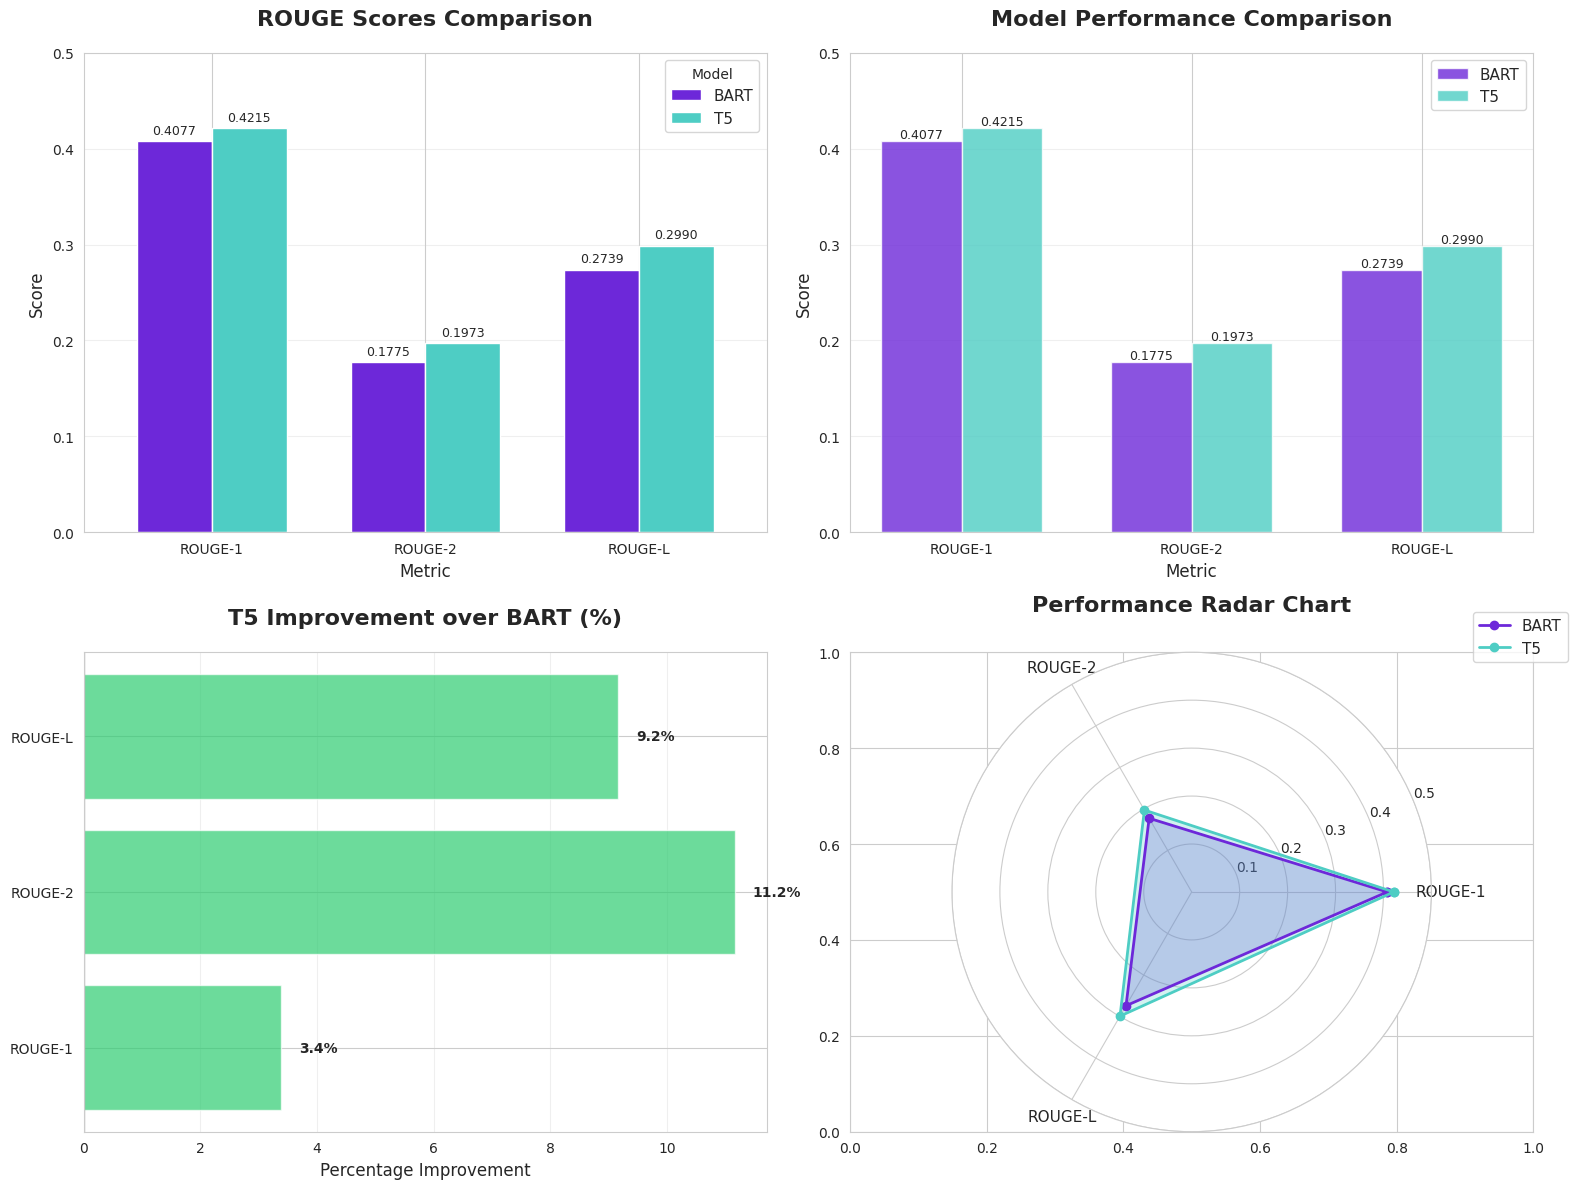


Chart saved to: /content/drive/MyDrive/clario-models/model_comparison.png


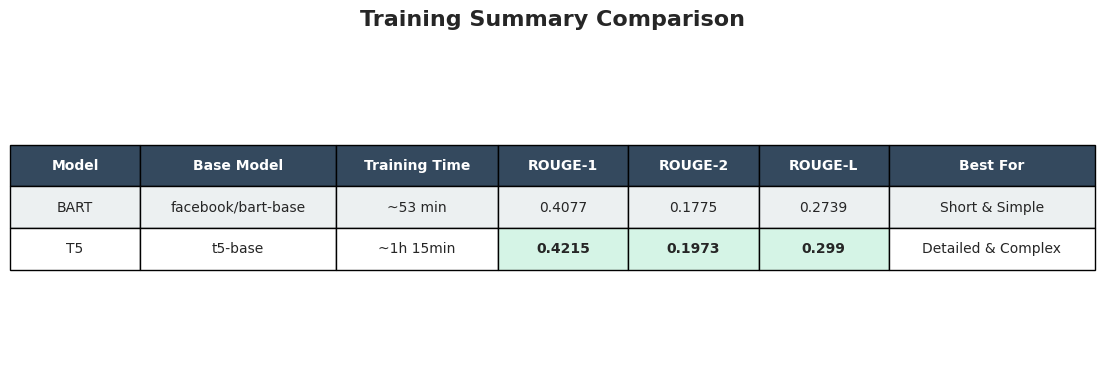

Summary saved to: /content/drive/MyDrive/clario-models/training_summary.png


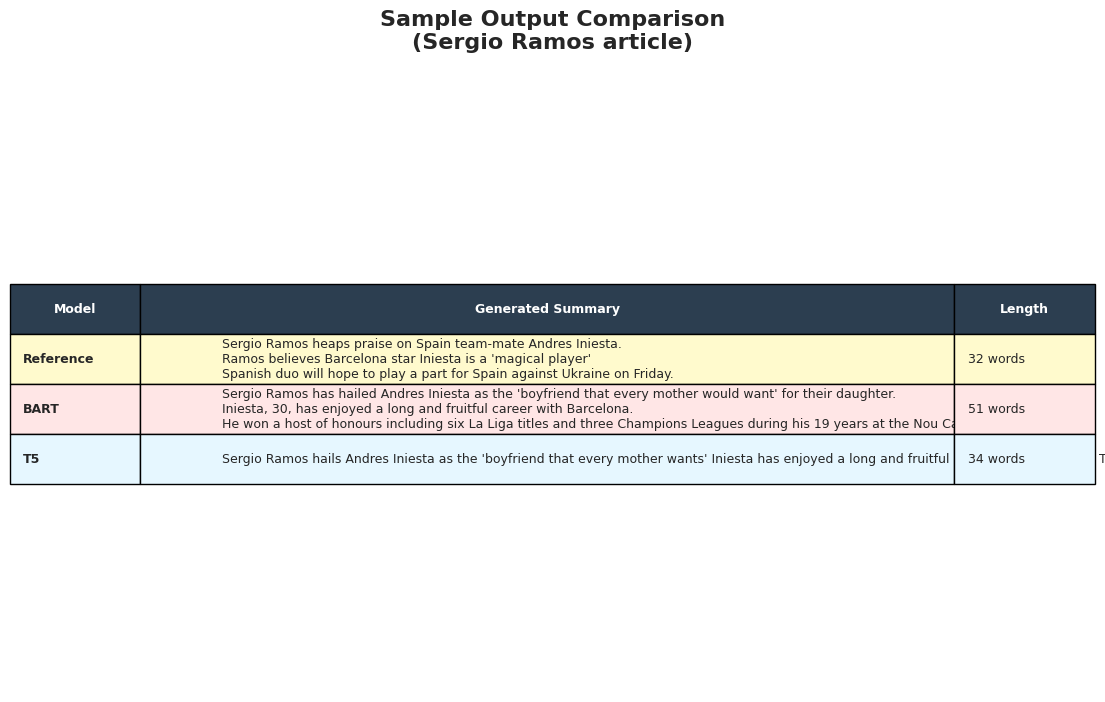

Sample comparison saved to: /content/drive/MyDrive/clario-models/sample_outputs.png


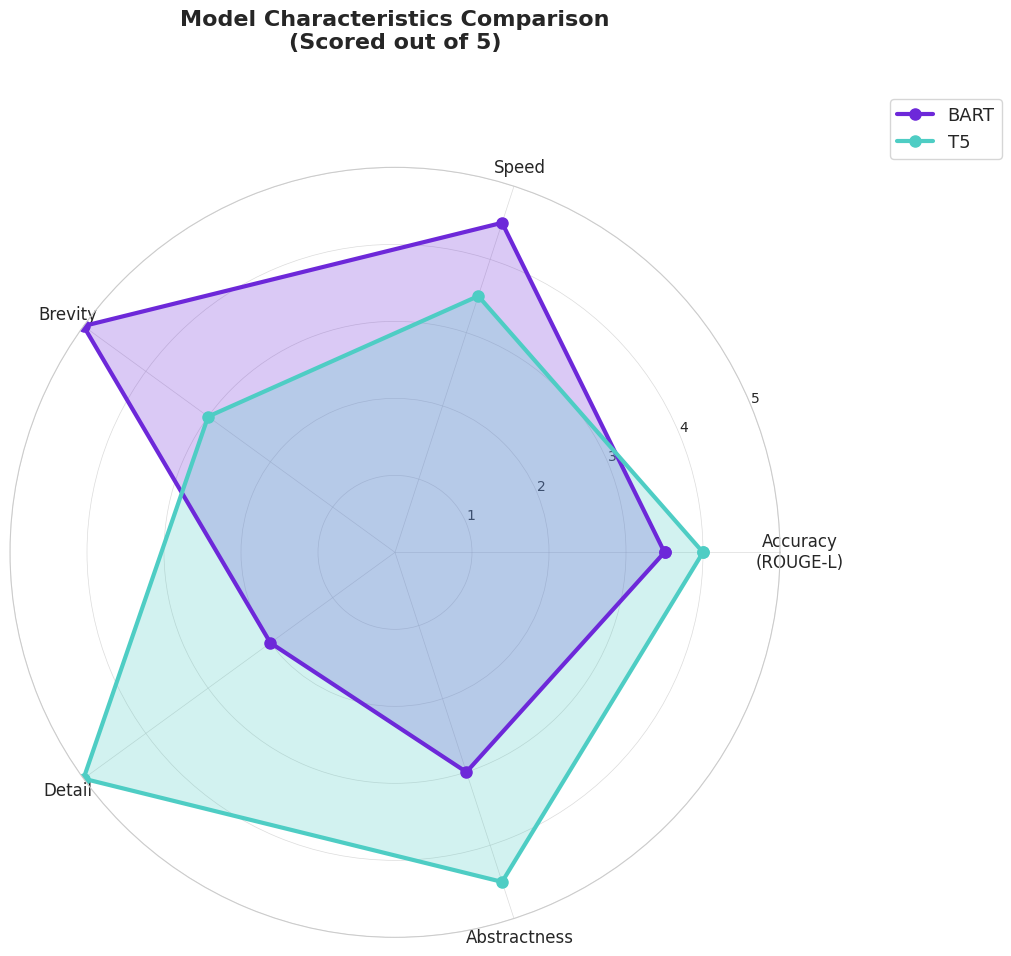

Characteristics chart saved to: /content/drive/MyDrive/clario-models/characteristics_comparison.png

-------------------------
Final training summary
-------------------------

Metric               BART            T5              Winner    
-------------------------
ROUGE-1              0.4077          0.4215          T5        
ROUGE-2              0.1775          0.1973          T5        
ROUGE-L              0.2739          0.2990          T5        
Training Time        ~53 min         ~1h 15min       BART      
Output Length        Shorter         Longer          Tie       
Best For             Concise         Detailed        -         
-------------------------


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# ROUGE Scores Comparison

bart_metrics = {
    'ROUGE-1': 0.4077,
    'ROUGE-2': 0.1775,
    'ROUGE-L': 0.2739
}
t5_metrics = {
    'ROUGE-1': 0.4215,
    'ROUGE-2': 0.1973,
    'ROUGE-L': 0.2990
}

#comparison dataframe
metrics_df = pd.DataFrame({
    'BART': list(bart_metrics.values()),
    'T5': list(t5_metrics.values())
}, index=list(bart_metrics.keys()))

# bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Bar chart comparison
ax1 = axes[0, 0]
metrics_df.plot(kind='bar', ax=ax1, color=['#6d28d9', '#4ecdc4'], width=0.7)
ax1.set_title('ROUGE Scores Comparison', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xlabel('Metric', fontsize=12)
ax1.legend(title='Model', fontsize=11)
ax1.set_ylim(0, 0.5)
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

# value labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.4f', padding=3, fontsize=9)

# Grouped comparison
ax2 = axes[0, 1]
x = np.arange(len(metrics_df.index))
width = 0.35
bars1 = ax2.bar(x - width/2, metrics_df['BART'], width, label='BART', color='#6d28d9', alpha=0.8)
bars2 = ax2.bar(x + width/2, metrics_df['T5'], width, label='T5', color='#4ecdc4', alpha=0.8)

ax2.set_title('Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_xlabel('Metric', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_df.index)
ax2.legend(fontsize=11)
ax2.set_ylim(0, 0.5)
ax2.grid(axis='y', alpha=0.3)

# value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Performance improvement (T5 vs BART)
ax3 = axes[1, 0]
improvement = ((metrics_df['T5'] - metrics_df['BART']) / metrics_df['BART'] * 100)
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in improvement]
bars = ax3.barh(improvement.index, improvement, color=colors, alpha=0.7)

ax3.set_title('T5 Improvement over BART (%)', fontsize=16, fontweight='bold', pad=20)
ax3.set_xlabel('Percentage Improvement', fontsize=12)
ax3.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax3.grid(axis='x', alpha=0.3)


for i, (bar, val) in enumerate(zip(bars, improvement)):
    ax3.text(val + (0.3 if val > 0 else -0.3), i, f'{val:.1f}%',
             va='center', ha='left' if val > 0 else 'right', fontsize=10, fontweight='bold')

# Radar chart
ax4 = axes[1, 1]
categories = list(bart_metrics.keys())
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

bart_values = list(bart_metrics.values())
bart_values += bart_values[:1]
t5_values = list(t5_metrics.values())
t5_values += t5_values[:1]

ax4 = plt.subplot(2, 2, 4, projection='polar')
ax4.plot(angles, bart_values, 'o-', linewidth=2, label='BART', color='#6d28d9')
ax4.fill(angles, bart_values, alpha=0.25, color='#6d28d9')
ax4.plot(angles, t5_values, 'o-', linewidth=2, label='T5', color='#4ecdc4')
ax4.fill(angles, t5_values, alpha=0.25, color='#4ecdc4')

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories, fontsize=11)
ax4.set_ylim(0, 0.5)
ax4.set_title('Performance Radar Chart', fontsize=16, fontweight='bold', pad=30)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax4.grid(True)

plt.tight_layout()
plt.savefig(f'{OUTPUT_BASE}/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nChart saved to: {OUTPUT_BASE}/model_comparison.png")

# Training Summary Table

summary_data = {
    'Model': ['BART', 'T5'],
    'Base Model': ['facebook/bart-base', 't5-base'],
    'Training Time': ['~53 min', '~1h 15min'],
    'ROUGE-1': [0.4077, 0.4215],
    'ROUGE-2': [0.1775, 0.1973],
    'ROUGE-L': [0.2739, 0.2990],
    'Best For': ['Short & Simple', 'Detailed & Complex']
}

summary_df = pd.DataFrame(summary_data)

plt.figure(figsize=(14, 4))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

table = ax.table(cellText=summary_df.values,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.12, 0.18, 0.15, 0.12, 0.12, 0.12, 0.19])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# header
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style
colors = ['#ecf0f1', '#ffffff']
for i in range(1, len(summary_df) + 1):
    for j in range(len(summary_df.columns)):
        table[(i, j)].set_facecolor(colors[(i-1) % 2])

        # best scores
        if j in [3, 4, 5]:  # ROUGE columns
            if i == 2:  # T5 row
                table[(i, j)].set_facecolor('#d5f4e6')
                table[(i, j)].set_text_props(weight='bold')

plt.title('Training Summary Comparison', fontsize=16, fontweight='bold', pad=20)
plt.savefig(f'{OUTPUT_BASE}/training_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Summary saved to: {OUTPUT_BASE}/training_summary.png")

# Sample output comparison

test_outputs = {
    'Reference': "Sergio Ramos heaps praise on Spain team-mate Andres Iniesta.\nRamos believes Barcelona star Iniesta is a 'magical player'\nSpanish duo will hope to play a part for Spain against Ukraine on Friday.",
    'BART': "Sergio Ramos has hailed Andres Iniesta as the 'boyfriend that every mother would want' for their daughter.\nIniesta, 30, has enjoyed a long and fruitful career with Barcelona.\nHe won a host of honours including six La Liga titles and three Champions Leagues during his 19 years at the Nou Camp.",
    'T5': "Sergio Ramos hails Andres Iniesta as the 'boyfriend that every mother wants' Iniesta has enjoyed a long and fruitful career with Barcelona. The 30-year-old has won six La Liga titles and three Champions Leagues."
}

fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')

cell_text = []
row_colors = []
for model, summary in test_outputs.items():
    # word count
    word_count = len(summary.split())
    cell_text.append([model, summary, f"{word_count} words"])

    if model == 'Reference':
        row_colors.append('#fffacd')
    elif model == 'BART':
        row_colors.append('#ffe6e6')
    else:
        row_colors.append('#e6f7ff')

table = ax.table(cellText=cell_text,
                colLabels=['Model', 'Generated Summary', 'Length'],
                cellLoc='left',
                loc='center',
                colWidths=[0.12, 0.75, 0.13])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 3)

# Header
for i in range(3):
    table[(0, i)].set_facecolor('#2c3e50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style
for i in range(1, len(test_outputs) + 1):
    for j in range(3):
        table[(i, j)].set_facecolor(row_colors[i-1])
        if j == 0:  # Model name column
            table[(i, j)].set_text_props(weight='bold')

plt.title('Sample Output Comparison\n(Sergio Ramos article)',
          fontsize=16, fontweight='bold', pad=20)
plt.savefig(f'{OUTPUT_BASE}/sample_outputs.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Sample comparison saved to: {OUTPUT_BASE}/sample_outputs.png")

# Model Characteristics Spider Chart

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = ['Accuracy\n(ROUGE-L)', 'Speed', 'Brevity', 'Detail', 'Abstractness']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Scores out of 5
bart_scores = [3.5, 4.5, 5, 2, 3]  # BART- faster, more concise, less detailed
t5_scores = [4, 3.5, 3, 5, 4.5]    # T5- better ROUGE, more detailed, slower

bart_scores += bart_scores[:1]
t5_scores += t5_scores[:1]

ax.plot(angles, bart_scores, 'o-', linewidth=3, label='BART', color='#6d28d9', markersize=8)
ax.fill(angles, bart_scores, alpha=0.25, color='#6d28d9')
ax.plot(angles, t5_scores, 'o-', linewidth=3, label='T5', color='#4ecdc4', markersize=8)
ax.fill(angles, t5_scores, alpha=0.25, color='#4ecdc4')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=10)
ax.set_title('Model Characteristics Comparison\n(Scored out of 5)',
             fontsize=16, fontweight='bold', pad=30, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=13)
ax.grid(True, linewidth=0.5, alpha=0.7)

plt.savefig(f'{OUTPUT_BASE}/characteristics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Characteristics chart saved to: {OUTPUT_BASE}/characteristics_comparison.png")


# Final Summary Stats

print("\n" + "-"*25)
print("Final training summary")
print("-"*25)
print(f"\n{'Metric':<20} {'BART':<15} {'T5':<15} {'Winner':<10}")
print("-"*25)
print(f"{'ROUGE-1':<20} {0.4077:<15.4f} {0.4215:<15.4f} {'T5':<10}")
print(f"{'ROUGE-2':<20} {0.1775:<15.4f} {0.1973:<15.4f} {'T5':<10}")
print(f"{'ROUGE-L':<20} {0.2739:<15.4f} {0.2990:<15.4f} {'T5':<10}")
print(f"{'Training Time':<20} {'~53 min':<15} {'~1h 15min':<15} {'BART':<10}")
print(f"{'Output Length':<20} {'Shorter':<15} {'Longer':<15} {'Tie':<10}")
print(f"{'Best For':<20} {'Concise':<15} {'Detailed':<15} {'-':<10}")
print("-"*25)
